# Housing Unit Allocation Full Workflow

## Overview
Given a building inventory that uses IN-CORE standards run housing unit allocation.
This process checks to see if the housing unit inventory is available and if not it will create it.
This process checks to see if the address point inventory is available and if not it will create it.

With the housing unit inventory and address point inventory will be uploaded to IN-CORE Dataservice.

With the required files the housing unit allocation method will run.
Functions to obtain and clean data required for the version 2 Housing Unit Allocation. 

## Required Inputs
Program requires the following inputs:
1. Building inventory file from pyincore
    - IN-CORE account
    
## Output Description
The output of this workflow is a CSV file with the housing unit inventory allocated to a building inventory using the housing unit allocation model.

The output CSV is designed to be used in the Interdependent Networked Community Resilience Modeling Environment (IN-CORE).

IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/


## Instructions
Users can run the workflow by executing each block of code in the notebook.

## Description of Program
- program:    ncoda_07dv1_HUA_fullworkflow
- task:       Start with building inventory and run housing unit allocation algorithm
- See github commits for description of program updates
- Current Version:    2022-08-29 - v2 workflow
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE), Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

## Setup Python Environment

In [2]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage.buildingdamage import BuildingDamage

from pyincore_viz.geoutil import GeoUtil as viz

In [3]:
import scooby # Reports Python environment

In [4]:
# Generate report of Python environment
print(scooby.Report(additional=['pandas']))


--------------------------------------------------------------------------------
  Date: Tue Aug 30 15:14:24 2022 Central Daylight Time

                OS : Windows
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45)
  [MSC v.1929 64 bit (AMD64)]

            pandas : 1.4.2
             numpy : 1.22.3
             scipy : 1.8.0
           IPython : 8.3.0
        matplotlib : 3.5.2
            scooby : 0.5.12
--------------------------------------------------------------------------------


In [5]:
# Check working directory - good practice for relative path access
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\IN-CORE\\Tasks\\PublishHUIv2\\HousingUnitInventories_2022-03-03\\ReplicationCode\\intersect-community-data'

In [6]:
# Edit Data Dictionary for Community
communities = {'SaltLakeCity_UT' : {
                    'community_name' : 'Salt Lake City, UT',
                    'counties' : { 
                        1 : {'FIPS Code' : '49035', 'Name' : 'Salt Lake City County, UT'}}}}

## Step 1: Set up pyincore and read in data
IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/

Registration is free.

In [7]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 

Connection successful to IN-CORE services. pyIncore version detected: 1.4.1


In [8]:
# create data_service object for loading files
data_service = DataService(client)

In [11]:
def upload_incore(data_service: pyincore.dataservice.DataService = data_service):
        # Check IN-CORE Data Service for filename
        print('Check IN-CORE Data Service for the file',hui_filename)
        matched_datasets = data_service.search_datasets(hui_filename)

        # Check if matched_datasets is empty
        if matched_datasets:
            # How many observations in  matched_datasets?
            print(f'There are {len(matched_datasets)} datasets matching {hui_filename}')
            if len(matched_datasets) == 1:
                hui_id = matched_datasets[0]['id']
            else:
                print("There are multiple datasets matching the filename. Please select one.")
                for i, dataset in enumerate(matched_datasets):
                    print(i,matched_datasets[i]['dataset']['id'])
                hui_id = matched_datasets[int(input("Enter dataset number: "))]['dataset']["id"]
            print('Using dataset',hui_id)
        else:
            print('No matching datasets in IN-CORE Data Service')
            print('Creating new dataset')
            # Create new dataset

### Read in Building Inventory

In [7]:
# Building inventory
bldg_inv_id = "62fea288f5438e1f8c515ef8" # SLC building inventory - Milad Roohi
# load building inventory
bldg_inv = Dataset.from_data_service(bldg_inv_id, data_service)
filename = bldg_inv.get_file_path('shp')
print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)

The IN-CORE Dataservice has saved the Building Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\62fea288f5438e1f8c515ef8\Salt Lake County All Building\Salt Lake County All Building.shp


In [8]:
bldg_inv_gdf = gpd.read_file(filename)
# Check CRS of building inventory
bldg_inv_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
from pyproj import CRS
# Update CRS to EPSG:4326 if not already in that format
if bldg_inv_gdf.crs != CRS.from_epsg(4326):
    bldg_inv_gdf = bldg_inv_gdf.to_crs(epsg=4326)
    print("The CRS of the building inventory has been updated to EPSG:4326")
else:
    print("The CRS of the building inventory is already in EPSG:4326")

The CRS of the building inventory is already in EPSG:4326


In [13]:
# Check Unique ID
bldg_inv_gdf[['guid','bldg_id']].astype(str).describe().T

,count,unique,top,freq
guid,284925,284925,6f8c3468-4696-4371-bc91-3a7ceec1e768,1
bldg_id,284925,112,16200000000000.0,17249


In [12]:
bldg_inv_gdf.head(1).T

,0
parid,28200000000000.0
parid_card,28200000000000.0
bldg_id,28200000000000.0
struct_typ,RM1L
archetype,COM3
str_prob,None
year_built,1993
no_stories,1
a_stories,None
b_stories,None


### Find Spatial Extent of Building Inventory
Need to know which counties are included in the building inventory.

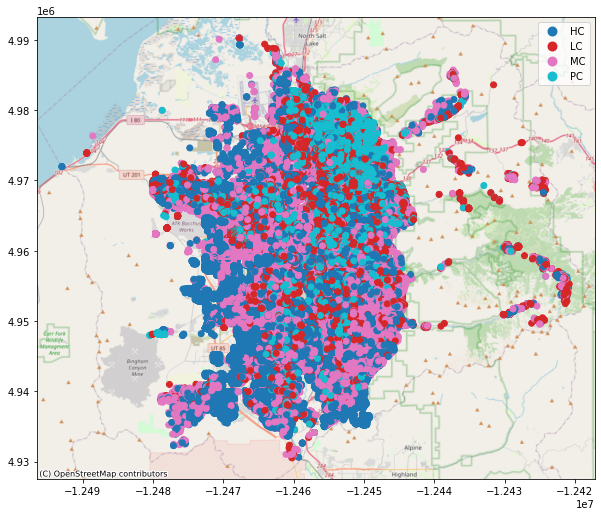

In [20]:
map = viz.plot_gdf_map(bldg_inv_gdf,column='dlevel')
map

#### Use Tract ID to find county FIPS code
The first 5 digits of the tract ID are the FIPS code for the county.

In [22]:
bldg_inv_gdf['tract_id'].describe()

count    2.849250e+05
mean     4.903511e+10
std      4.125693e+03
min      4.903510e+10
25%      4.903511e+10
50%      4.903511e+10
75%      4.903511e+10
max      4.903511e+10
Name: tract_id, dtype: float64

In [24]:
# Substring of tractid to get county 5 digit fips code 
# covert tract_id to string with leading zeros
bldg_inv_gdf['tract_id_str'] = bldg_inv_gdf['tract_id'].astype(str).str.zfill(11)
bldg_inv_gdf['county'] = bldg_inv_gdf['tract_id_str'].str[:5]
bldg_inv_gdf[['tract_id_str','county']].describe()

,tract_id_str,county
count,284925,284925
unique,193,1
top,49035113104,49035
freq,8331,284925


### Building Inventory File has 1 county
The Salt Late City building inventory only has 1 county.

#### Find Counties using spatial extent of data file
To Do - use the spatial extent to locate counties in the building inventory.

Might be able to merge the building inventory with the block id first to get the county FIPS codes.

In [16]:
'''
buffer_dist: buffer distance in degrees for lat/lon around point bounds
     - https://en.wikipedia.org/wiki/Decimal_degrees
     - example: 0.001 for 1/1000th of a degree or approximately 100 meters
     - example: 0.0001 for 1/10000th of a degree or approximately 10 meter
'''

buffer_dist = 0.001
# What is the center of the building inventory?
minx = bldg_inv_gdf.bounds.minx.min() - buffer_dist # subtract buffer from minimum values
miny = bldg_inv_gdf.bounds.miny.min() - buffer_dist
maxx = bldg_inv_gdf.bounds.maxx.max() + buffer_dist
maxy = bldg_inv_gdf.bounds.maxy.max() + buffer_dist
bldg_inv_gdf_bounds = [minx, miny, maxx, maxy]

In [19]:
# What location should the map be centered on?
center_x = (minx + maxx)/2
center_y = (miny + maxy)/2
print(f'The center of the building inventory data file is located at {center_x} {center_y}')

The center of the building inventory data file is located at -111.9021242 40.646511235


### Check if Housing Unit Inventory Available on IN-CORE Data Service

For more information see:

Rosenheim, Nathanael, Roberto Guidotti, Paolo Gardoni & Walter Gillis Peacock. (2019). Integration of detailed household and housing unit characteristic data with critical infrastructure for post-hazard resilience modeling. Sustainable and Resilient Infrastructure. doi.org/10.1080/23789689.2019.1681821

Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. https://doi.org/10.17603/ds2-jwf6-s535.

In [42]:
version = '2.0.0'
version_text = 'v2-0-0'

# Set random seed for reproducibility
seed = 1000
basevintage = 2010

for community in communities.keys():
    # Create empty container to store outputs for in-core
    # Will use these to combine multiple counties
    hua_incore_county_df = {}
    print("Checking Housing Unit Inventory for",communities[community]['community_name'])
    for county in communities[community]['counties'].keys():
        state_county = communities[community]['counties'][county]['FIPS Code']
        state_county_name  = communities[community]['counties'][county]['Name']
        print(state_county_name,': county FIPS Code',state_county)

        hui_filename = f'hui_{version_text}_{community}_{basevintage}_rs{seed}'

        # Check IN-CORE Data Service for filename
        print('Check IN-CORE Data Service for the file',hui_filename)
        matched_datasets = data_service.search_datasets(hui_filename)

        # Check if matched_datasets is empty
        if matched_datasets:
            # How many observations in  matched_datasets?
            print(f'There are {len(matched_datasets)} datasets matching {hui_filename}')
            if len(matched_datasets) == 1:
                hui_id = matched_datasets[0]['id']
            else:
                print("There are multiple datasets matching the filename. Please select one.")
                for i, dataset in enumerate(matched_datasets):
                    print(i,matched_datasets[i]['dataset']['id'])
                hui_id = matched_datasets[int(input("Enter dataset number: "))]['dataset']["id"]
            print('Using dataset',hui_id)
        else:
            print('No matching datasets in IN-CORE Data Service')
            print('Creating new dataset')
            # Create new dataset

Checking Housing Unit Inventory for Salt Lake City, UT
Salt Lake City County, UT : county FIPS Code 49035
Check IN-CORE Data Service for the file hui_v2-0-0_SaltLakeCity_UT_2010_rs1000
No matching datasets in IN-CORE Data Service
Creating new dataset


In [10]:
# Housing Unit inventory
housing_unit_inv_id = "6262ef3204ce841cbeb30993"
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\6262ef3204ce841cbeb30993\hui_v2-0-0_Lumberton_NC_2010_rs1000\hui_v2-0-0_Lumberton_NC_2010_rs1000.csv


In [11]:
housing_unit_inv_df = pd.read_csv(filename, header="infer")

In [12]:
housing_unit_inv_df['huid'].describe()

count                    52801
unique                   52801
top       B371559601011003H001
freq                         1
Name: huid, dtype: object

### Read in Address Point Inventory
The address point inventory is an intermediate file based on the building inventory. The address point inventory acts as the bridge between the building inventory and the housing unit inventory.

In [13]:
# Address Point inventory
addpt_inv_id = "60aac382088dfa3b65030b16"
# load housing unit inventory as pandas dataframe
addpt_inv = Dataset.from_data_service(addpt_inv_id, data_service)
filename = addpt_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\60aac382088dfa3b65030b16\IN-CORE_2fv1_Lumberton_Inventories_addresspointinventory\IN-CORE_2fv1_Lumberton_Inventories_addresspointinventory.csv


In [15]:
addpt_inv_df = pd.read_csv(filename, header="infer")
addpt_inv_df['addrptid'].describe()

count                                              61505
unique                                             61505
top       ST2d32aeff-7b75-47e6-b7a5-4f4adca4b021AP000000
freq                                                   1
Name: addrptid, dtype: object

## Step 2: Housing Unit Allocation v2

### Setup notebook environment to access Cloned Github Package
This notebook uses functions that are in development. The current version of the package is available at:

https://github.com/npr99/intersect-community-data

Nathanael Rosenheim. (2022). npr99/intersect-community-data. Zenodo. https://doi.org/10.5281/zenodo.6476122

A permanent copy of the package and example datasets are available in the DesignSafe-CI repository:

Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

In [16]:
#To replicate this notebook Clone the Github Package to a folder that is a sibling of this notebook.
# To access the sibling package you will need to append the parent directory ('..') to the system path list.
# append the path of the directory that includes the github repository.
# This step is not required when the package is in a folder below the notebook file.
github_code_path  = ""
sys.path.append(github_code_path)

In [17]:
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\IN-CORE\\Tasks\\PublishHUIv2\\HousingUnitInventories_2022-03-03\\ReplicationCode\\intersect-community-data'

In [18]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2
# open, read, and execute python program with reusable commands
from pyncoda.ncoda_05a_hua_functions \
    import hua_workflow_functions
from pyncoda.ncoda_00b_directory_design import directory_design
from pyncoda.ncoda_06c_Codebook import *
from pyncoda.ncoda_04a_Figures import *

from pyncoda.CommunitySourceData.api_census_gov.acg_00e_incore_huiv2 \
    import incore_v2_DataStructure

### Setup Housing Unit Allocation

In [19]:
# Example of data dictionary for one community with one county
communities = {'Lumberton_NC' : {
                    'community_name' : 'Lumberton, NC',
                    'counties' : { 
                        1 : {'FIPS Code' : '37155', 'Name' : 'Robeson County, NC'}}}}

In [71]:
version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"
# Make directory to save output
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Set random seed for reproducibility
seed = 1000
basevintage = 2010


### Run Housing Unit Allocation

In [84]:
for community in communities.keys():
    # Create empty container to store outputs for in-core
    # Will use these to combine multiple counties
    hua_incore_county_df = {}
    print("Setting up Housing Unit Inventory for",communities[community]['community_name'])
    for county in communities[community]['counties'].keys():
        state_county = communities[community]['counties'][county]['FIPS Code']
        state_county_name  = communities[community]['counties'][county]['Name']
        print(state_county_name,': county FIPS Code',state_county)
    
        outputfolders = directory_design(state_county_name = state_county_name,
                                            outputfolder = outputfolder)
                                            
        generate_df = hua_workflow_functions(
            hui_df = housing_unit_inv_df,
            addpt_df=addpt_inv_df,
            bldg_df=bldg_inv_gdf,
            state_county = state_county,
            state_county_name= state_county_name,
            seed = seed,
            version = version,
            version_text = version_text,
            basevintage = basevintage,
            outputfolder = outputfolder,
            outputfolders = outputfolders)

        # Generate base housing unit inventory
        base_hua_df = generate_df.run_hua_workflow(savelog=False)

        # Save version for IN-CORE in v2 format
        hua_incore_county_df[state_county] = base_hua_df['primary']

    # combine multiple counties
    hua_incore_df = pd.concat(hua_incore_county_df.values(), 
                                    ignore_index=True, axis=0)

    # Convert HUA to geodataframe format
    hua_incore_gdf = gpd.GeoDataFrame(
        hua_incore_df, geometry=gpd.points_from_xy(hua_incore_df.x, hua_incore_df.y))

    # Merge building inventory with housing unit allocation results
    huav2_gdf = pd.merge(left = hua_incore_gdf, 
                        right = bldg_inv_gdf[['guid','archetype','geometry']], 
                        on='guid', how='outer')

    # If Geometry is null, use X,Y coordinates from Address Point
    # use geometry_y unless missing - then use geometry_x
    huav2_gdf['geometry'] = huav2_gdf['geometry_y']
    huav2_gdf.loc[huav2_gdf['geometry'].isnull(), 'geometry'] = huav2_gdf['geometry_x']
    # drop geometry_x and geometry_y columns
    huav2_gdf.drop(columns=['geometry_x','geometry_y'], inplace=True)

    # Convert Block2010 to string
    # fill in missing values
    huav2_gdf['Block2010'] = huav2_gdf['Block2010'].fillna(371550000000000)
    huav2_gdf['Block2010'] = huav2_gdf['Block2010'].apply(lambda x : str(int(x)).zfill(15))

    #Save results for community name
    output_filename = f'hua_{version_text}_{community}_{basevintage}_rs{seed}'
    csv_filepath = outputfolders['top']+"/"+output_filename+'.csv'
    savefile = sys.path[0]+"/"+csv_filepath
    huav2_gdf.to_csv(savefile, index=False)

    # Save second set of files in common directory
    common_directory = outputfolders['top']+"/../"+output_filename
    huav2_gdf.to_csv(common_directory+'.csv', index=False)


Setting up Housing Unit Inventory for Lumberton, NC
Robeson County, NC : county FIPS Code 37155

***************************************
    Run Housing Unit Allocation for Robeson County, NC
***************************************


***************************************
    Merge housing unit and address point data with first 3 counters.
***************************************

Round 1

***************************************
***************************************

Performing random merge at geography level: Block

***************************************
***************************************


***************************************
***************************************

Attempt to merge hui on all common group vars.

***************************************
***************************************

Running random merge by ['Block2010', 'huicounter1', 'ownershp1']

***************************************
    Setting up  primary data with primary key and flags
********************

## Check block with missing huid match


In [94]:
from pyncoda.ncoda_04b_foliummaps import *

In [100]:
# Check guid with missing address point id
condition1 = (huav2_gdf['guid'] == '099d5476-aaec-42d8-b0d1-e14eee17b373')
gdf1 = huav2_gdf.loc[condition1].copy()

folium_marker_layer_map(gdf = gdf1,
                        gdfvar="archetype",
                        layername = "",
                        color_levels = [0,1,2,3,4,5,6,7])